In [ ]:
## Baseado em v8.99.
# Criado a partir das sugestões do André Nicolella após a reunião com a Globus Seguros, em 06/05/2025.
#    - Inserir tabelas de classificação do Finscore Bruto, Ajustado e Final.
#    - Mantido na metodologia a mescla (merge) do Finscore (patrimônio) e do Serasa (histórico de crédito).

<a href='https://colab.research.google.com/github/fernandovieira1/FinScore/blob/main/FINSCORE.ipynb' target='_parent'><img src='https://colab.research.google.com/assets/colab-badge.svg' alt='Open In Colab'/></a>

**# INTRUÇÕES**

* Antes de iniciar, certifique-se de estar logado na sua conta Google.

* Um botão azul 'Fazer login', localizado no canto superior direito da tela, aparecerá, se não.

* Feito isto, basta inserir os dados nas seções abaixo descritas:
    - 1.1 Cliente
    - 1.2 Período
    - 1.3 Score Serasa
    - 1.4 Lançamento dos dados Contábeis (na planilha indicada no link)

* Cada uma das seções mencionadas possui anotações sobre como proceder.

* Logo após, clique no menu 'Ambiente de execução' e em 'Executar tudo' (ou CTR + F9), nesta ordem.

##### 1. LANÇAMENTO DOS DADOS #####

##### 1.1 Cliente

*--> Insira o nome do cliente/empresa*

In [57]:
# Cliente
cliente = 'NOME DA EMPRESA'

##### 1.2 Período dos Demonstrativos Contábeis

*--> Insira os anos inicial (a primeira) e final (da última) das demonstrações contábeis que serviram de base para a análise*

In [58]:
# Ano Inicial
ano_inicial = 2021

In [59]:
# Ano Final
ano_final = 2023

##### 1.3 Score Serasa

*--> Insira o score Serasa do cliente*

In [60]:
# Serasa
serasa = 550

*--> Insira a data do score Serasa do cliente no formato dia/mês/ano (dd/mm/aaaa) e entre parênteses.*

In [61]:
# Data do score Serasa
data_serasa = '06/05/2025'

##### 1.4 Lançamento dos dados Contábeis

*--> Acesse a planilha abaixo (CTRL + click) e insira as informações nas linhas e colunas respectivas*

In [62]:
# Lance do ano mais recente para o mais antigo
'https://docs.google.com/spreadsheets/d/1qx6nagvF8okAKvfO9BoHL2aZUZ8NOnz2/edit?gid=1575975872#gid=1575975872'

'https://docs.google.com/spreadsheets/d/1qx6nagvF8okAKvfO9BoHL2aZUZ8NOnz2/edit?gid=1575975872#gid=1575975872'

*--> Agora basta clicar no menu 'Ambiente de execução' e em 'Executar tudo' (ou CTR + F9), nesta ordem.*

##### CONFIGURAÇÃO DO AMBIENTE

##### Pacotes/bibliotecas

In [63]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

import sys
import subprocess
import importlib.util


In [64]:
%%capture
# Lista de pacotes necessários
required_packages = ['gspread', 'pandas', 'gspread_dataframe', 'openpyxl']

# Verificar e instalar pacotes que não estão instalados
def install_missing_packages(packages):
    for package in packages:
        if importlib.util.find_spec(package) is None:
            print(f'⚠ Instalando {package}...')
            subprocess.check_call([sys.executable, '-m', 'pip', 'install', '--upgrade', package])
        else:
            print(f'✔ {package} já está instalado')

install_missing_packages(required_packages)

Fontes dos dados

In [65]:
# Definir o ID da planilha e da aba (worksheet)
sheet_id = '1qx6nagvF8okAKvfO9BoHL2aZUZ8NOnz2'
gid = '1575975872'  # ID da aba específica

# Construir a URL para baixar a planilha como um arquivo Excel (.xlsx)
url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=xlsx&id={sheet_id}&gid={gid}'

# Ler a planilha diretamente no Pandas
df_dados_contabeis = pd.read_excel(url, engine='openpyxl')

Funções ad hoc

In [66]:
## CALCULAR INDICES CONTÁBEIS
def calcular_indices_contabeis(df):
    indices = {}

    ### RENTABILIDADE
    indices['Margem Líquida'] = df['r_Lucro_Liquido'] / df['r_Receita_Total']
    # Percentual da receita que sobra como lucro líquido.

    indices['ROA'] = df['r_Lucro_Liquido'] / df['p_Ativo_Total']
    # Retorno sobre ativos: eficiência global da operação.

    indices['ROE'] = df['r_Lucro_Liquido'] / df['p_Patrimonio_Liquido']
    # Retorno sobre o patrimônio líquido: rentabilidade para o acionista.

    ### EBITDA
    ebit = df['r_Lucro_Liquido'] + df['r_Despesa_de_Juros'] + df['r_Despesa_de_Impostos']
    amort = df.get('r_Amortizacao', 0).fillna(0)
    depr = df.get('r_Depreciacao', 0).fillna(0)
    ebitda = ebit + amort + depr
    indices['EBITDA'] = ebitda
    indices['Margem EBITDA'] = ebitda / df['r_Receita_Total']
    # Percentual da receita que vira caixa operacional antes de juros, impostos e depreciação.

    ### ALAVANCAGEM E ENDIVIDAMENTO
    df['p_Divida_Bruta'] = df['p_Passivo_Total'] - df['p_Patrimonio_Liquido']
    # Endividamento Bruto (passivo exigível)

    df['p_Divida_Liquida'] = df['p_Divida_Bruta'] - df['p_Caixa']
    # Dívida Líquida (ajustada pelo caixa disponível)

    indices['Alavancagem'] = df['p_Divida_Liquida'] / ebitda
    # Mede quantos anos de geração operacional (EBITDA) seriam necessários para quitar a dívida líquida.

    indices['Endividamento'] = df['p_Divida_Bruta'] / df['p_Ativo_Total']
    # Percentual dos ativos financiado exclusivamente por capital de terceiros.

    ### ESTRUTURA DE CAPITAL
    df['p_Imobilizado'] = df['p_Ativo_Total'] - df['p_Ativo_Circulante']
    # Estimativa do Ativo Imobilizado

    indices['Imobilizado/Ativo'] = df['p_Imobilizado'] / df['p_Ativo_Total']
    # Percentual do ativo total que está imobilizado (capital fixo).

    ### COBERTURA DE JUROS
    indices['Cobertura de Juros'] = ebit / df['r_Despesa_de_Juros']
    # Mede a capacidade da empresa de pagar seus juros com o lucro operacional (EBIT).

    ### EFICIÊNCIA OPERACIONAL
    indices['Giro do Ativo'] = df['r_Receita_Total'] / df['p_Ativo_Total']
    # Mede quantas vezes os ativos se transformam em receita no período.

    ### CICLO OPERACIONAL
    indices['Período Médio de Recebimento'] = df['p_Contas_a_Receber'] / df['r_Receita_Total'] * 365
    indices['Período Médio de Pagamento'] = df['p_Contas_a_Pagar'] / df['r_Custos'] * 365
    # Dias médios para receber e pagar.

    ### LIQUIDEZ
    indices['Liquidez Corrente'] = df['p_Ativo_Circulante'] / df['p_Passivo_Circulante']
    # Mede a capacidade de pagar obrigações de curto prazo.

    indices['Liquidez Seca'] = (df['p_Ativo_Circulante'] - df['p_Estoques']) / df['p_Passivo_Circulante']
    # Medida mais conservadora de liquidez, desconsidera estoques.

    indices['CCL/Ativo Total'] = (df['p_Ativo_Circulante'] - df['p_Passivo_Circulante']) / df['p_Ativo_Total']
    # Mede a folga de capital de giro em relação ao total de ativos da empresa.


    ### Criar DataFrame
    df_indices = pd.DataFrame(indices)

    ### Tratar divisões por zero e valores infinitos
    df_indices.replace([np.inf, -np.inf], np.nan, inplace=True)

    return df_indices


In [67]:
## FORMATAR DATAS
# Função para converter formato de data dd/mm/aaaa para yyyy-mm-dd
def converter_formato_data(data_string):
    try:
        # Se a data já estiver no formato yyyy-mm-dd, retorna como está
        if len(data_string.split('-')) == 3:
            return data_string
            
        # Se for formato dd/mm/aaaa, converte para yyyy-mm-dd
        dia, mes, ano = data_string.split('/')
        return f"{ano}-{mes.zfill(2)}-{dia.zfill(2)}"
    except Exception as e:
        print(f"Erro ao converter data: {e}")
        return data_string

data_serasa = converter_formato_data(data_serasa)

##### Importação dos Dados Contábeis

In [68]:
## Importar os dados
# - Do mais recente para o mais antigo

# arquivo_dados_contabeis = '/content/dados_contabeis_global.xlsx'
arquivo_dados_contabeis = df_dados_contabeis

In [69]:
arquivo_dados_contabeis

,ano,p_Ativo_Circulante,p_Ativo_Total,p_Caixa,p_Estoques,p_Contas_a_Pagar,p_Contas_a_Receber,p_Passivo_Circulante,p_Passivo_Total,p_Patrimonio_Liquido,r_Amortizacao,r_Custos,r_Depreciacao,r_Despesa_de_Impostos,r_Despesa_de_Juros,r_Lucro_Liquido,r_Receita_Total
0,0,29716613,58240254,0,0,6048227,8920741,6279752,58240254,12106709,0,67838821,0,0,31879,100893,73372438
1,1,35030579,67992387,0,0,16076322,10463734,16514038,67992387,10874130,0,33665834,0,0,334490,1496210,49372166
2,2,37531910,80987685,0,0,19191518,7861523,25235400,80987685,14031963,0,32800463,0,0,1144121,3748957,45676317


##### Leitura dos Dados Contábeis

In [70]:
df_dados_contabeis = arquivo_dados_contabeis
print('Dados Contabeis Importados:')
print(df_dados_contabeis)

Dados Contabeis Importados:
   ano  p_Ativo_Circulante  p_Ativo_Total  p_Caixa  p_Estoques  \
0    0            29716613       58240254        0           0   
1    1            35030579       67992387        0           0   
2    2            37531910       80987685        0           0   

   p_Contas_a_Pagar  p_Contas_a_Receber  p_Passivo_Circulante  \
0           6048227             8920741               6279752   
1          16076322            10463734              16514038   
2          19191518             7861523              25235400   

   p_Passivo_Total  p_Patrimonio_Liquido  r_Amortizacao  r_Custos  \
0         58240254              12106709              0  67838821   
1         67992387              10874130              0  33665834   
2         80987685              14031963              0  32800463   

   r_Depreciacao  r_Despesa_de_Impostos  r_Despesa_de_Juros  r_Lucro_Liquido  \
0              0                      0               31879           100893   
1        

##### 2. PROCESSAMENTO DO MODELO #####

##### 2.1 Índices contábeis

In [71]:
df_indices = calcular_indices_contabeis(df_dados_contabeis).round(2)
print('\nÍndices Contábeis Calculados:')


Índices Contábeis Calculados:


In [72]:
if (df_dados_contabeis['p_Estoques'] == 0).all():
        del df_indices['Liquidez Seca']

In [73]:
print(df_indices)

   Margem Líquida   ROA   ROE   EBITDA  Margem EBITDA  Alavancagem  \
0            0.00  0.00  0.01   132772           0.00       347.46   
1            0.03  0.02  0.14  1830700           0.04        31.20   
2            0.08  0.05  0.27  4893078           0.11        13.68   

   Endividamento  Imobilizado/Ativo  Cobertura de Juros  Giro do Ativo  \
0           0.79               0.49                4.16           1.26   
1           0.84               0.48                5.47           0.73   
2           0.83               0.54                4.28           0.56   

   Período Médio de Recebimento  Período Médio de Pagamento  \
0                         44.38                       32.54   
1                         77.36                      174.30   
2                         62.82                      213.56   

   Liquidez Corrente  CCL/Ativo Total  
0               4.73             0.40  
1               2.12             0.27  
2               1.49             0.15  


##### 2.2 Padronização dos índices contábeis

In [74]:
# Escalar os índices contábeis para o PCA
scaler = StandardScaler()
indices_scaled = scaler.fit_transform(df_indices)
print('\nÍndices Escalados para PCA:')
print(indices_scaled)


Índices Escalados para PCA:
[[-1.1111678  -1.13554995 -1.22474487 -1.09286499 -1.09985336  1.41267511
  -1.38873015 -0.50800051 -0.8061489   1.37535374 -1.27006502 -1.38383806
   1.39023519  1.24074398]
 [-0.20203051 -0.16222142  0.         -0.23089278 -0.21997067 -0.64922553
   0.9258201  -0.88900089  1.40935123 -0.40254256  1.1737357   0.43944297
  -0.47054114 -0.03265116]
 [ 1.31319831  1.29777137  1.22474487  1.32375777  1.31982404 -0.76344958
   0.46291005  1.3970014  -0.60320233 -0.97281118  0.09632932  0.94439509
  -0.91969405 -1.20809282]]


##### 2.3 Cálculo do PCA

In [75]:
# Realizar o PCA
pca = PCA()
pca_result = pca.fit_transform(indices_scaled)
print('\nComponentes Principais (PCA):')
print(pca_result)

#relatório



Componentes Principais (PCA):
[[ 4.40713052e+00 -8.54068358e-01 -3.46049193e-16]
 [-7.50506373e-01  2.36982746e+00 -3.46049193e-16]
 [-3.65662415e+00 -1.51575910e+00 -3.46049193e-16]]


##### 2.4 Variância Explicada PCA

In [76]:
# Variância explicada pelos componentes principais
explained_variance_ratio = pca.explained_variance_ratio_
print('\nVariância Explicada por Componente:')
print(explained_variance_ratio)

#relatório


Variância Explicada por Componente:
[7.94213319e-01 2.05786681e-01 8.55357458e-33]


##### 2.5 DataFrame PCA

In [77]:
# DataFrame com os componentes principais
pca_df = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])
print('\nMatriz de Componentes Principais:')
print(pca_df)

#relatório


Matriz de Componentes Principais:
        PC1       PC2           PC3
0  4.407131 -0.854068 -3.460492e-16
1 -0.750506  2.369827 -3.460492e-16
2 -3.656624 -1.515759 -3.460492e-16


##### 2.6 Matriz de cargas

In [78]:
# Obter a matriz de cargas
loadings = pd.DataFrame(
    pca.components_,
    columns=df_indices.columns,
    index=[f'PC{i+1}' for i in range(pca.components_.shape[0])]
)

print('Matriz de Cargas dos Componentes Principais:')
print(loadings)

# Identificar os índices mais significativos para cada PC
print('\nÍndices mais significativos por componente:')
for pc in loadings.index:
    print(f'\n{pc}:')
    print(loadings.loc[pc].abs().sort_values(ascending=False).head(3))  # Top 3 índices mais significativos

#relatório

Matriz de Cargas dos Componentes Principais:
     Margem Líquida       ROA       ROE    EBITDA  Margem EBITDA  Alavancagem  \
PC1       -0.286216 -0.288642 -0.296071 -0.284306      -0.285044     0.284940   
PC2       -0.175894 -0.159864 -0.093764 -0.187468      -0.183093    -0.183716   
PC3        0.424988  0.690044 -0.043079 -0.190974      -0.192743    -0.012181   

     Endividamento  Imobilizado/Ativo  Cobertura de Juros  Giro do Ativo  \
PC1      -0.255054          -0.200256           -0.072094       0.297410   
PC2       0.309896          -0.438553            0.571875      -0.075674   
PC3       0.157642          -0.157142            0.188303       0.254524   

     Período Médio de Recebimento  Período Médio de Pagamento  \
PC1                     -0.204769                   -0.296246   
PC2                      0.430434                    0.091614   
PC3                     -0.235951                    0.005078   

     Liquidez Corrente  CCL/Ativo Total  
PC1           0.295083

##### 2.7 Escore final

In [79]:
pca_df.dot(explained_variance_ratio)

0    3.324446
1   -0.108383
2   -3.216063
dtype: float64

##### 3. RESULTADOS #####

##### 3.1A FINSCORE BRUTO

In [80]:
# Função para categorizar escores consolidados com mais granularidade
def categorias_finscore_bruto(escores):
    categorias = []
    for escore in escores:
        if finscore_bruto > 1.5:
            categorias.append('Muito Abaixo do Risco')
        elif 1.0 < escore <= 1.5:
            categorias.append('Levemente Abaixo do Risco')
        elif -1.0 <= escore <= 1.0:
            categorias.append('Neutro')
        elif -1.5 < escore < -1.0:
            categorias.append('Levemente Acima do Risco')
        else:
            categorias.append('Muito Acima do Risco')
    return categorias

# Tabela de Categorias:
# -------------------------------------------------------
# |   Intervalo do Escore   |      Categoria            |
# -------------------------------------------------------
# |  escore > 1.5           | Muito Abaixo do Risco     |
# |  1.0 < escore ≤ 1.5     | Levemente Abaixo do Risco |
# | -1.0 ≤ escore ≤ 1.0     | Neutro                    |
# | -1.5 < escore < -1.0    | Levemente Acima do Risco  |
# |  escore ≤ -1.5          | Muito Acima do Risco      |
# -------------------------------------------------------

In [81]:
# Calcular o escore consolidado com penalização do último ano
# Do mais recente para o mais antigo: 0.5, 0.3, 0.2
pesos = [0.6, 0.25, 0.15]  # Pesos para os três anos
finscore_bruto = round((pca_df.dot(explained_variance_ratio) * pesos).sum(), 2)
print('\nFINSCORE BRUTO:')
print(finscore_bruto)
print('\nCLASSIFICAÇÃO FINSCORE BRUTO:')
print(categorias_finscore_bruto([finscore_bruto])[0])



FINSCORE BRUTO:
1.49

CLASSIFICAÇÃO FINSCORE BRUTO:
Levemente Abaixo do Risco


##### 3.1B FINSCORE AJUSTADO

In [82]:
# Função para categorizar escores consolidados com mais granularidade
def categorias_finscore_ajustado(escores):
    categorias = []
    for escore in escores:
        if escore > 750:
            categorias.append('Muito Abaixo do Risco')
        elif 500 < escore <= 750:
            categorias.append('Levemente Abaixo do Risco')
        elif 250 <= escore <= 500:
            categorias.append('Neutro')
        elif 100 < escore < 250:
            categorias.append('Levemente Acima do Risco')
        else:
            categorias.append('Muito Acima do Risco')
    return categorias

# Tabela de Categorias:
# -------------------------------------------------------
# |   Intervalo do Escore  |      Categoria            |
# -------------------------------------------------------
# |  escore > 750          | Muito Abaixo do Risco     |
# |  500 < escore ≤ 750    | Levemente Abaixo do Risco |
# | 250 ≤ escore ≤ 500     | Neutro                    |
# | 100 < escore < 250     | Levemente Acima do Risco  |
# |  escore ≤ 250          | Muito Acima do Risco      |
# -------------------------------------------------------

In [83]:
# Traduz a tendência em um escore de risco ajustado ao ponto de referência atual do cliente.
finscore_ajustado = round(min(((finscore_bruto + 2)/4)*1000, 1000), 2)

In [84]:
print('\nFINSCORE AJUSTADO:')
print(finscore_ajustado)
print('\nCLASSIFICAÇÃO FINSCORE AJUSTADO:')
print(categorias_finscore_ajustado([finscore_ajustado])[0])


FINSCORE AJUSTADO:
872.5

CLASSIFICAÇÃO FINSCORE AJUSTADO:
Muito Abaixo do Risco


##### 3.1C FINSCORE FINAL

In [85]:
# Função para categorizar escores consolidados com mais granularidade
def categorias_finscore_final(escores):
    categorias = []
    for escore in escores:
        if escore > 750:
            categorias.append('Muito Abaixo do Risco')
        elif 500 < escore <= 750:
            categorias.append('Levemente Abaixo do Risco')
        elif 250 <= escore <= 500:
            categorias.append('Neutro')
        elif 100 < escore < 250:
            categorias.append('Levemente Acima do Risco')
        else:
            categorias.append('Muito Acima do Risco')
    return categorias

# Tabela de Categorias:
# -------------------------------------------------------
# |   Intervalo do Escore  |      Categoria            |
# -------------------------------------------------------
# |  escore > 750          | Muito Abaixo do Risco     |
# |  500 < escore ≤ 750    | Levemente Abaixo do Risco |
# | 250 ≤ escore ≤ 500     | Neutro                    |
# | 100 < escore < 250     | Levemente Acima do Risco  |
# |  escore ≤ 250          | Muito Acima do Risco      |
# -------------------------------------------------------

In [86]:
finscore_final = min(round(((serasa + finscore_ajustado) / 2) + ((serasa * finscore_ajustado)/1000), 2), 1000)


In [87]:
print('\nFINSCORE FINAL:')
print(finscore_final)
print('\nCLASSIFICAÇÃO FINSCORE FINAL:')
print(categorias_finscore_final([finscore_final])[0])



FINSCORE FINAL:
1000

CLASSIFICAÇÃO FINSCORE FINAL:
Muito Abaixo do Risco


##### 3.2 SERASA

In [88]:
# Função para categorizar escores conforme a classificação do Serasa
def categorias_serasa(escores):
    categorias = []
    for escore in escores:
        if escore >= 701:
            categorias.append('Excelente')
        elif 501 <= escore <= 700:
            categorias.append('Bom')
        elif 301 <= escore <= 500:
            categorias.append('Baixa')
        else:
            categorias.append('Muito Baixa')
    return categorias

# Tabela de Categorias:
# ---------------------------------
# |   Intervalo do Escore  | Categoria  |
# ---------------------------------
# |  701 a 1.000          | Excelente  |
# |  501 a 700            | Bom        |
# |  301 a 500            | Baixo      |
# |  0 a 300              | Muito Baixo|
# ---------------------------------

In [89]:
print('\nSERASA:')
print(serasa)
print('\nCLASSIFICAÇÃO SERASA:')
print(categorias_serasa([serasa])[0])


SERASA:
550

CLASSIFICAÇÃO SERASA:
Bom


##### 3.3 Valores e Contas Contábeis

In [90]:
df_dados_contabeis
# Sendo 0 o mais recente e 2 o mais antigo

,ano,p_Ativo_Circulante,p_Ativo_Total,p_Caixa,p_Estoques,p_Contas_a_Pagar,p_Contas_a_Receber,p_Passivo_Circulante,p_Passivo_Total,p_Patrimonio_Liquido,r_Amortizacao,r_Custos,r_Depreciacao,r_Despesa_de_Impostos,r_Despesa_de_Juros,r_Lucro_Liquido,r_Receita_Total,p_Divida_Bruta,p_Divida_Liquida,p_Imobilizado
0,0,29716613,58240254,0,0,6048227,8920741,6279752,58240254,12106709,0,67838821,0,0,31879,100893,73372438,46133545,46133545,28523641
1,1,35030579,67992387,0,0,16076322,10463734,16514038,67992387,10874130,0,33665834,0,0,334490,1496210,49372166,57118257,57118257,32961808
2,2,37531910,80987685,0,0,19191518,7861523,25235400,80987685,14031963,0,32800463,0,0,1144121,3748957,45676317,66955722,66955722,43455775


##### 3.4 Índices contábeis

In [91]:
print(df_indices)
# Sendo 0 o mais recente e 2 o mais antigo


   Margem Líquida   ROA   ROE   EBITDA  Margem EBITDA  Alavancagem  \
0            0.00  0.00  0.01   132772           0.00       347.46   
1            0.03  0.02  0.14  1830700           0.04        31.20   
2            0.08  0.05  0.27  4893078           0.11        13.68   

   Endividamento  Imobilizado/Ativo  Cobertura de Juros  Giro do Ativo  \
0           0.79               0.49                4.16           1.26   
1           0.84               0.48                5.47           0.73   
2           0.83               0.54                4.28           0.56   

   Período Médio de Recebimento  Período Médio de Pagamento  \
0                         44.38                       32.54   
1                         77.36                      174.30   
2                         62.82                      213.56   

   Liquidez Corrente  CCL/Ativo Total  
0               4.73             0.40  
1               2.12             0.27  
2               1.49             0.15  


##### 4. APRESENTAÇÃO #####

##### 4.1 Criação dos dfs

In [92]:
categorias_serasa([serasa])[0]

'Bom'

In [93]:
# Df resultados principais
resultados_df = pd.DataFrame({
    'Métrica': ['Finscore Bruto', 'Finscore Ajustado', 'Finscore', 'Serasa'],
    'Valor': [finscore_bruto, finscore_ajustado, finscore_final, serasa],
    'Cateegoria': [categorias_finscore_bruto([finscore_bruto])[0], 
                   categorias_finscore_ajustado([finscore_ajustado])[0], 
                   categorias_finscore_final([finscore_final])[0],
                   categorias_serasa([serasa])[0]]
                   
})
resultados_df

,Métrica,Valor,Cateegoria
0,Finscore Bruto,1.49,Levemente Abaixo do Risco
1,Finscore Ajustado,872.50,Muito Abaixo do Risco
2,Finscore,1000.00,Muito Abaixo do Risco
3,Serasa,550.00,Bom


##### 4.2 Tabela Resumo

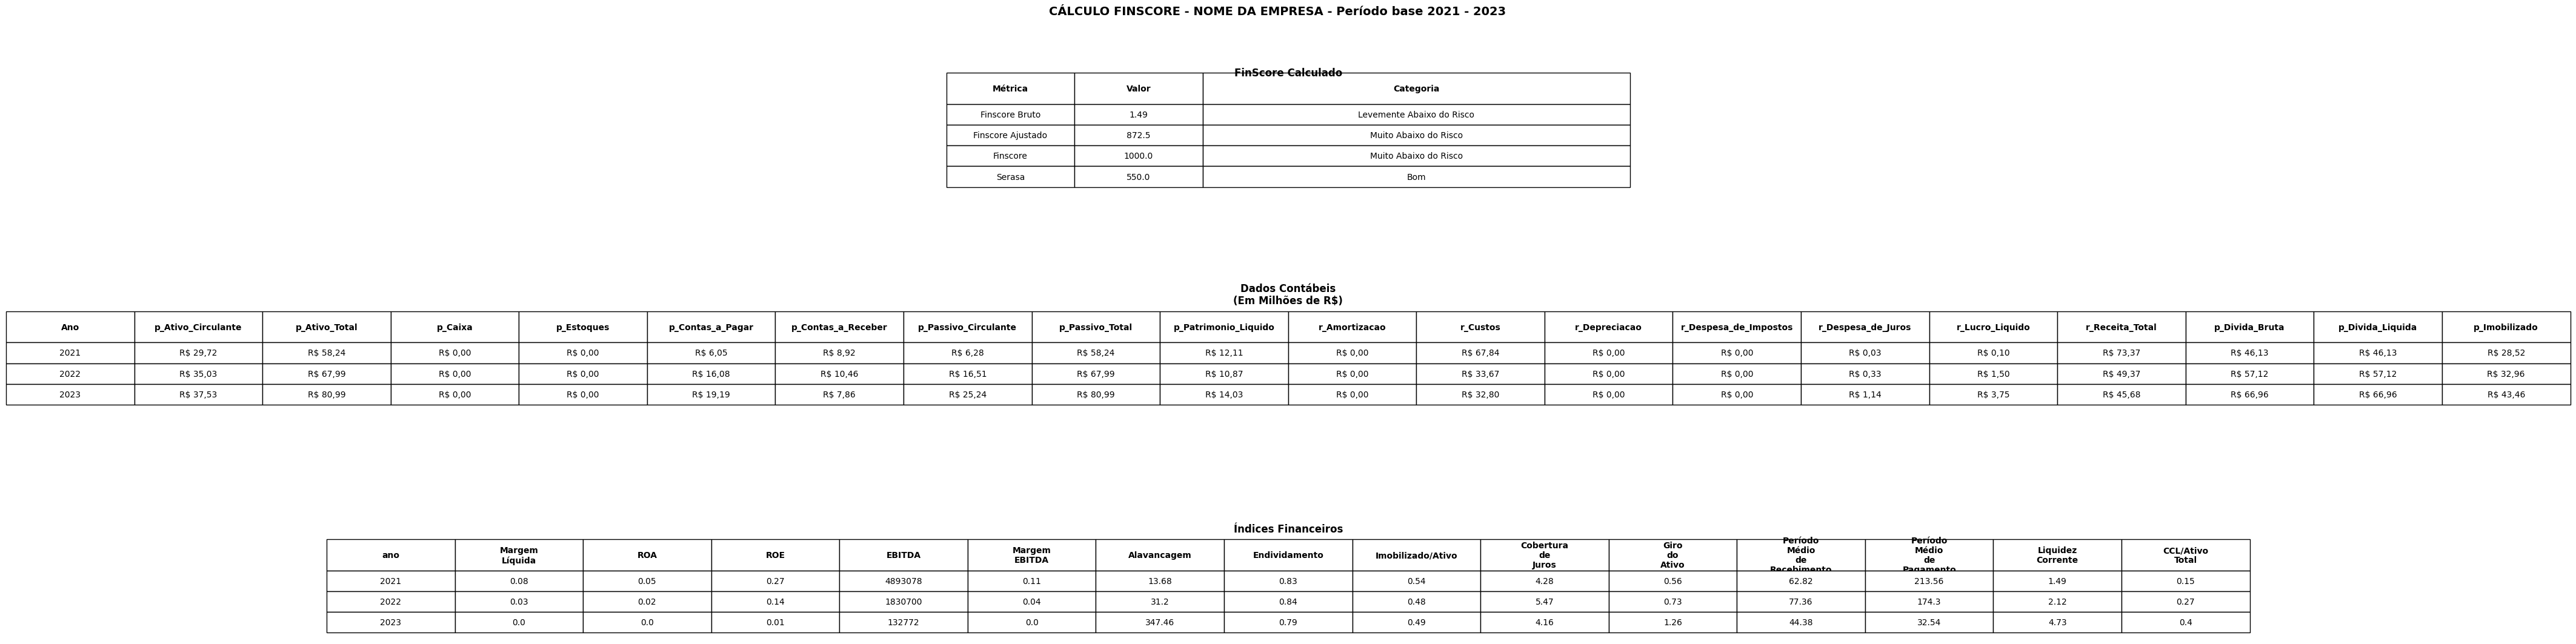

In [94]:

# --- Ajuste principal: inverter a ordem do df_indices se necessário ---
df_indices = df_indices.iloc[::-1].reset_index(drop=True)

## FORMATAR PADRÃO BR
# Cópia do df original
df_dados_contabeis_milhoes = df_dados_contabeis.copy()

# Excluindo a coluna 'Ano' antes de realizar as transformações
df_dados_contabeis_milhoes = df_dados_contabeis_milhoes.drop(columns=['ano'])

# Dividindo os valores das colunas numéricas por 1.000.000
for col in df_dados_contabeis_milhoes.select_dtypes(include=['float64', 'int64']).columns:
    df_dados_contabeis_milhoes[col] = df_dados_contabeis_milhoes[col] / 1_000_000

# Formatando os valores para o padrão brasileiro (R$ 1.000.000,00)
df_dados_contabeis_milhoes = df_dados_contabeis_milhoes.map(
    lambda x: f'R$ {x:,.2f}'.replace(',', 'X').replace('.', ',').replace('X', '.')
    if isinstance(x, (int, float)) else x
)

## INSERIR A COLUNA 'ANO' NAS TABELAS 'Dados Contábeis' e 'Índices Financeiros'
anos = list(map(str, range(ano_inicial, ano_final + 1)))  # Criando lista correta de anos

# Ajustando tamanho das listas de anos conforme o número de linhas nos DataFrames
df_dados_contabeis_milhoes.insert(0, 'Ano', anos[:len(df_dados_contabeis_milhoes)])
df_indices.insert(0, 'ano', anos[:len(df_indices)])

## DF RESULTADOS PRINCIPAIS
resultados_df = pd.DataFrame({
    'Métrica': ['Finscore Bruto', 'Finscore Ajustado', 'Finscore', 'Serasa'],
    'Valor': [finscore_bruto, finscore_ajustado, finscore_final, serasa],
    'Categoria': [
        categorias_finscore_bruto([finscore_bruto])[0],
        categorias_finscore_ajustado([finscore_ajustado])[0],
        categorias_finscore_final([finscore_final])[0],
        categorias_serasa([serasa])[0]
    ]
})

## INSERINDO QUEBRA DE LINHA NOS CABEÇALHOS
df_dados_contabeis_milhoes.columns = [col.replace(' ', '\n') for col in df_dados_contabeis_milhoes.columns]
df_indices.columns = [col.replace(' ', '\n') for col in df_indices.columns]
resultados_df.columns = [col.replace(' ', '\n') for col in resultados_df.columns]

## CABEÇALHO
fig, axs = plt.subplots(nrows=3, figsize=(14, 12))

# Ajustando o espaçamento entre os subplots
plt.subplots_adjust(hspace=1.2)  # Aumentando a separação entre as tabelas

fig.suptitle(
    f'CÁLCULO FINSCORE - {cliente} - Período base {ano_inicial} - {ano_final}',
    fontsize=14, fontweight='bold'
)

## TABELAS
def add_table(ax, df, title, top_padding=0.5):
    ax.axis('tight')
    ax.axis('off')

    # Ajuste dinâmico da largura das colunas
    num_cols = len(df.columns)
    col_widths = [0.15] * num_cols  # Largura padrão
    if 'Categoria' in df.columns:
        col_widths[-1] = 0.5  # Maior largura para 'Categoria'

    table = ax.table(
        cellText=df.values,
        colLabels=df.columns,
        cellLoc='center', loc='center',
        colWidths=col_widths
    )
    
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.3, 1.3)  # Ajustando escala para melhor legibilidade
    
    # Aumentando a altura da linha do cabeçalho
    for col in range(len(df.columns)):
        table[(0, col)].set_height(0.3)
    
    # Destacando o cabeçalho com negrito
    for key, cell in table._cells.items():
        if key[0] == 0:  # Se for a primeira linha (cabeçalho)
            cell.set_fontsize(10)
            cell.set_text_props(weight='bold')
        else:
            cell.set_text_props(ha='center', va='center', wrap=True)  # Ajuste para quebras de linha
            cell.set_height(0.2)  # Aumentando altura para melhor ajuste de texto

    # Ajustar a posição do título para ficar mais centralizado
    ax.set_title(title, fontsize=12, fontweight='bold', pad=top_padding)
    ax.title.set_y(1.1)  # Levando o título um pouco para cima

# Adicionando cada tabela com ajuste fino do título
add_table(axs[0], resultados_df, 'FinScore Calculado', top_padding=1.0)
add_table(axs[1], df_dados_contabeis_milhoes, 'Dados Contábeis\n(Em Milhões de R$)', top_padding=1.5)
add_table(axs[2], df_indices, 'Índices Financeiros', top_padding=1.5)

plt.show()


#### 5. Prompt IA

In [95]:
print('Faça um parecer em língua portuguesa com base no prompt abaixo, pronto para ser copiado e colado em um processador de texto (word, libreoffice ou google docs):')

print('\n========================== INÍCIO ==========================')

print('- Gere um relatório detalhado de análise de crédito para o cliente abaixo, considerando sua situação financeira com base nos dados contábeis, índices financeiros e classificação final do FinScore.')

# **1️⃣ Introdução**
print('\n1️⃣ INTRODUÇÃO:')
print('--------------------------------------')
print('Este parecer tem como objetivo fornecer uma análise detalhada da situação financeira da empresa analisada, utilizando os demonstrativos financeiros disponíveis.')
print(f'Nome da Empresa: {cliente}')
print(f'Período da Análise: {ano_inicial} - {ano_final}')
print(f'Score do Serasa: {serasa}')
print(f'Data do Serasa Score: {data_serasa}')
print('Serão avaliados os dados contábeis, índices financeiros e scores de risco para apresentar um veredito sobre a viabilidade da concessão de crédito à empresa.')

# **2️⃣ Metodologia**
print('\n2️⃣ METODOLOGIA:')
print('--------------------------------------')
print('A análise financeira desta empresa segue as diretrizes metodológicas do FinScore, conforme descrito no documento de referência.')

print('\n🔹 **O que é o FinScore e como ele é calculado?**')
print('O FinScore é um indicador consolidado que avalia a saúde financeira da empresa com base em índices financeiros e técnicas estatísticas avançadas. Ele pode ser apresentado em três versões:')

print('- **FinScore Bruto:** Obtido diretamente a partir da soma ponderada dos componentes principais do PCA (Análise de Componentes Principais). Seu valor original está na faixa de -2 a +2.')
print('- **FinScore Ajustado:** Transformação do FinScore Bruto para uma escala mais intuitiva de 0 a 1000.')
print('- **FinScore Final:** Combinação do FinScore Ajustado com o Serasa Score, aplicando uma ponderação específica para refletir tanto a análise contábil quanto o risco de crédito do mercado.')

# **Tabelas de Classificação do FinScore**
print('\n🔹 **Classificação do FinScore Bruto**')
print('-------------------------------------------------------')
print('|   Intervalo do Escore   |      Categoria            |')
print('-------------------------------------------------------')
print('|  escore > 1.5           | Muito Abaixo do Risco     |')
print('|  1.0 < escore ≤ 1.5     | Levemente Abaixo do Risco |')
print('| -1.0 ≤ escore ≤ 1.0     | Neutro                    |')
print('| -1.5 < escore < -1.0    | Levemente Acima do Risco  |')
print('|  escore ≤ -1.5          | Muito Acima do Risco      |')
print('-------------------------------------------------------')

print('\n🔹 **Classificação do FinScore Ajustado**')
print('-------------------------------------------------------')
print('|   Intervalo do Escore  |      Categoria            |')
print('-------------------------------------------------------')
print('|  escore > 750          | Muito Abaixo do Risco     |')
print('|  500 < escore ≤ 750    | Levemente Abaixo do Risco |')
print('| 250 ≤ escore ≤ 500     | Neutro                    |')
print('| 100 < escore < 250     | Levemente Acima do Risco  |')
print('|  escore ≤ 100          | Muito Acima do Risco      |')
print('-------------------------------------------------------')

print('\n🔹 **Classificação do FinScore Final**')
print('-------------------------------------------------------')
print('|   Intervalo do Escore  |      Categoria            |')
print('-------------------------------------------------------')
print('|  escore > 750          | Muito Abaixo do Risco     |')
print('|  500 < escore ≤ 750    | Levemente Abaixo do Risco |')
print('| 250 ≤ escore ≤ 500     | Neutro                    |')
print('| 100 < escore < 250     | Levemente Acima do Risco  |')
print('|  escore ≤ 100          | Muito Acima do Risco      |')
print('-------------------------------------------------------')

print('\n🔹 **Papel do Serasa Score na Análise**')
print('O Serasa Score é um indicador de crédito baseado no histórico financeiro da empresa. Ele complementa o FinScore, permitindo avaliar não apenas a estrutura financeira, mas também o comportamento de pagamento no mercado.')

# **3️⃣ Análise dos Dados Contábeis**
print('\n3️⃣ ANÁLISE DOS DADOS CONTÁBEIS:')
print('--------------------------------------')
print('Os seguintes dados contábeis foram extraídos para a análise financeira:')
print(df_dados_contabeis)
print("""
Monte a tabela com todos os valores listados em 'df_dados_contabeis' e critique cada uma das contas a seguir de forma contextualizada 
em relação aos objetivos deste trabalho: Ativo Circulante, Passivo Circulante, Estoques, Lucro Líquido, Receita Total, Ativo Total, 
Patrimônio Líquido, Passivo Total, EBIT, Despesa de Juros, Contas a Receber, Contas a Pagar, Custos""")

print('\n🔎 **Interprete sobretudo os valores apresentados a seguir e critique-os:**')
print('- Como está a relação entre **Ativo Circulante** e **Passivo Circulante**? A empresa tem liquidez suficiente?')
print('- O **Lucro Líquido** está positivo ou negativo? Se negativo, quais são os impactos financeiros?')
print('- A empresa está altamente alavancada? O **Endividamento** indica que a empresa depende muito de capital de terceiros?')

# **4️⃣ Análise dos Índices Financeiros**
print('\n4️⃣ ANÁLISE DOS ÍNDICES FINANCEIROS:')
print('--------------------------------------')
print('Os índices financeiros são fundamentais para avaliar a liquidez, rentabilidade e estrutura de capital da empresa.')
print(df_indices)
print("""
Monte a tabela com todos os valores listados em 'df_indices' e critique ums por um dos valores a seguir de forma 
contextualizada em relação aos objetivos deste trabalho: Liquidez Corrente, Liquidez Seca, Margem Líquida, ROA, ROE, Endividamento,
Cobertura de Juros, Giro do Ativo, Período Médio de Recebimento, Período Médio de Pagamento""")

print('\n🔎 **Critique e interprete sobretudo estes índices:**')
print('- **Liquidez Corrente e Seca:** Índices abaixo de 1 podem indicar risco de liquidez.')
print('- **Margem Líquida:** Se for muito baixa, pode comprometer a rentabilidade no longo prazo.')
print('- **ROA e ROE:** Retornos negativos sugerem que os ativos ou o patrimônio não estão gerando lucro suficiente.')
print('- **Endividamento e Cobertura de Juros:** Alto endividamento com baixa cobertura de juros pode indicar risco elevado.')

# **5️⃣ Análise dos FinScores e Serasa Score**
print('\n5️⃣ ANÁLISE DOS FINSCORES E SERASA SCORE:')
print('--------------------------------------')
print(f'- **Finscore Bruto:** {finscore_bruto:.2f} | **Categoria:** {categorias_finscore_bruto}')
print(f'- **Finscore Ajustado:** {finscore_ajustado:.2f} | **Categoria:** {categorias_finscore_ajustado}')
print(f'- **Finscore Final:** {finscore_final:.2f} | **Categoria:** {categorias_finscore_final}')
print(f'- **Serasa Score:** {serasa:.2f} | **Categoria:** {categorias_serasa}')
print('Com base nos conceito de cada um dos finscores e do serasa score, qual a sua avaliação sobre a situação financeira da empresa?')
print('Reflita com parcimômia e acurácia técnica com base em todos os conceitos, informações auferidas e nos objetivos e propósitos desta metodologia.')

# **6️⃣ Veredicto Final**
print('\n6️⃣ VEREDICTO FINAL:')
print('--------------------------------------')
print('O **FinScore Final** é o parâmetro definitivo da análise, pois sintetiza todos os índices e informações disponíveis.')
print('baseado em tudo o que foi registrado e analisado, qual a sua opinião final para a concessão de crédito a esta empresa? Com base em quais informações você chegou a essa conclusão?')

# **7️⃣ Recomendações para Mitigação de Riscos**
print('\n7️⃣ RECOMENDAÇÕES PARA MITIGAÇÃO DE RISCOS:')
print('--------------------------------------')
print('- Implementação de garantias reais, como recebíveis ou bens ativos.')
print('- Estabelecimento de um limite de crédito condizente com a capacidade de pagamento.')
print('- Monitoramento contínuo dos indicadores financeiros da empresa.')

print('\n========================== FIM ==========================')


Faça um parecer em língua portuguesa com base no prompt abaixo, pronto para ser copiado e colado em um processador de texto (word, libreoffice ou google docs):

========================== INÍCIO ==========================
- Gere um relatório detalhado de análise de crédito para o cliente abaixo, considerando sua situação financeira com base nos dados contábeis, índices financeiros e classificação final do FinScore.

1️⃣ INTRODUÇÃO:
--------------------------------------
Este parecer tem como objetivo fornecer uma análise detalhada da situação financeira da empresa analisada, utilizando os demonstrativos financeiros disponíveis.
Nome da Empresa: NOME DA EMPRESA
Período da Análise: 2021 - 2023
Score do Serasa: 550
Data do Serasa Score: 2025-05-06
Serão avaliados os dados contábeis, índices financeiros e scores de risco para apresentar um veredito sobre a viabilidade da concessão de crédito à empresa.

2️⃣ METODOLOGIA:
--------------------------------------
A análise financeira desta empr

In [ ]:
## Alterações feitas em 06-07/05/2025:
#    - Data do score Serasa: variável e função.
#    - Readequação do prompt: inclusão das tabelas de classificação do Finscore Bruto, Ajustado e Final.
#    - Reorganização do código: funções e variáveis foram reordenadas para facilitar a leitura e manutenção.